`Notebook: 03_model.ipynb`

- Purpose:

   - Market-Driven Prediction Accuracy
   - Business Usability & Interpretability
   - Deployment Readiness & Scalability

## 1.Packages Import

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests, ccf
import numpy as np
import plotly.express as px
from datetime import datetime
import geopandas as gpd
import warnings
from pathlib import Path
import yaml
from tqdm import tqdm
import pickle
from shap import initjs
import xgboost
import shap
import IPython.display as display 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

initjs()

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# sys.path.append("../scripts")

import plotly.io as pio
pio.renderers.default = 'vscode'  # or 'notebook'

sys.path.append(os.path.abspath("../scripts"))  # Adjust the path
os.chdir(os.path.dirname(os.path.abspath("__file__")))  # Set working directory

from utils import *


## 2.Dataset Loading

In [2]:
# Save as Parquet
df_optimized_merged = pd.read_parquet('../datasets/processed/df_optimized_merged.parquet', engine='fastparquet')

In [3]:
df_optimized_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841648 entries, 0 to 841647
Columns: 125 entries, start_date to other_conventional_mw_installed_gen
dtypes: UInt32(1), category(2), datetime64[ns](4), float32(114), float64(3), int8(1)
memory usage: 417.4 MB


In [4]:
df_optimized_merged.columns

Index(['start_date', 'end_date_x', 'region_type', 'region_name', 'hour_of_day',
       'date', 'week_of_year', 'hydro_pumped_storage_actual_consum',
       'residual_load_actual_consum', 'total_grid_load_actual_consum',
       ...
       'hydropower_mw_installed_gen', 'wind_offshore_mw_installed_gen',
       'wind_onshore_mw_installed_gen', 'photovoltaics_mw_installed_gen',
       'other_renewable_mw_installed_gen', 'lignite_mw_installed_gen',
       'hard_coal_mw_installed_gen', 'fossil_gas_mw_installed_gen',
       'hydro_pumped_storage_mw_installed_gen',
       'other_conventional_mw_installed_gen'],
      dtype='object', length=125)

In [5]:
cols_to_drop = ['start_date', 'end_date_x', 'end_date_y', 'region_type', 'region_name', 'date']

df_analysis = df_optimized_merged.drop(columns=cols_to_drop)

In [27]:
df_optimized_merged[['start_date', 'end_date_x', 'end_date_y','region_type', 'region_name', 'hour_of_day',
       'date', 'week_of_year', 'hydro_pumped_storage_actual_consum',
       'residual_load_actual_consum', 'total_grid_load_actual_consum',
       'hydropower_mw_installed_gen', 'wind_offshore_mw_installed_gen',
       'wind_onshore_mw_installed_gen', 'photovoltaics_mw_installed_gen',
       'other_renewable_mw_installed_gen', 'lignite_mw_installed_gen',
       'hard_coal_mw_installed_gen', 'fossil_gas_mw_installed_gen',
       'hydro_pumped_storage_mw_installed_gen',
       'other_conventional_mw_installed_gen']].head().T

,0,1,2,3,4
start_date,2023-01-01 00:00:00,2023-01-01 00:00:00,2023-01-01 00:00:00,2023-01-01 00:00:00,2023-01-01 00:00:00
end_date_x,2023-01-01 01:00:00,2023-01-01 01:00:00,2023-01-01 01:00:00,2023-01-01 01:00:00,2023-01-01 01:00:00
end_date_y,2024-01-01 00:00:00,2024-01-01 00:00:00,2024-01-01 00:00:00,2024-01-01 00:00:00,2024-01-01 00:00:00
region_type,bidding_zone,bidding_zone,bidding_zone,bidding_zone,bidding_zone
region_name,germany/luxembourg,germany/luxembourg,germany/luxembourg,germany/luxembourg,germany/luxembourg
hour_of_day,0,0,0,0,0
date,2023-01-01 00:00:00,2023-01-01 00:00:00,2023-01-01 00:00:00,2023-01-01 00:00:00,2023-01-01 00:00:00
week_of_year,52,52,52,52,52
hydro_pumped_storage_actual_consum,494.0,494.0,494.0,494.0,494.0
residual_load_actual_consum,1842.5,1842.5,1842.5,1842.5,1842.5


## 3.Modelling

In [6]:
def preprocess_data(df, target_col):
    """
    Prepares the dataset for training by handling missing values, scaling features, and splitting into train-test sets.
    """
    # Drop irrelevant columns
    # drop_cols = ['start_date', 'end_date_x', 'end_date_y', 'region_type', 'region_name', 'date']
    # df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

    # Handle missing data
    df = df.dropna(subset=[target_col])  # Remove rows where target is missing
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    # Standardize features
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    # Define target and features
    features = [col for col in df_scaled.columns if col != target_col]

    # Split into train and test sets (80-20)
    X_train, X_test, y_train, y_test = train_test_split(df_scaled[features], df_scaled[target_col], test_size=0.2, shuffle=False)

    return X_train, X_test, y_train, y_test, df_scaled


In [7]:
def train_model(X_train, y_train, X_test, model_type='rf', n_estimators=5):
    """
    Trains a machine learning model (Random Forest or Linear Regression) and returns predictions.
    """
    if model_type == 'rf':
        model = RandomForestRegressor(n_estimators=1, random_state=42, warm_start=True, n_jobs=-1)
        
        # Training loop with incremental estimators
        for i in tqdm(range(3, n_estimators + 1), desc="Training Random Forest", unit="trees"):
            model.n_estimators = i  
            model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
    
    elif model_type == 'lr':
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    else:
        raise ValueError("Unsupported model type. Choose 'rf' or 'lr'.")

    return model, y_pred

def evaluate_model(y_test, y_pred_rf, y_pred_lr, rf_model, features, df_scaled, target_col):
    """
    Computes multiple evaluation metrics for the trained models.
    """
    results = {}

    # Compute RMSE
    results["RMSE_RF"] = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    results["RMSE_LR"] = np.sqrt(mean_squared_error(y_test, y_pred_lr))

    # Directional Accuracy
    direction_actual = np.sign(y_test.diff()).dropna().reset_index(drop=True)
    direction_pred_rf = np.sign(pd.Series(y_pred_rf).diff()).dropna().reset_index(drop=True)
    direction_pred_lr = np.sign(pd.Series(y_pred_lr).diff()).dropna().reset_index(drop=True)

    results["Directional_Accuracy_RF"] = (direction_actual == direction_pred_rf).mean() * 100
    results["Directional_Accuracy_LR"] = (direction_actual == direction_pred_lr).mean() * 100

    # Volatility Capture
    actual_volatility = y_test.std()
    predicted_volatility_rf = np.std(y_pred_rf)
    results["Volatility_Capture"] = (predicted_volatility_rf / actual_volatility) * 100

    # Extreme Price Movement Detection
    actual_change = y_test.pct_change().dropna()
    predicted_change_rf = pd.Series(y_pred_rf).pct_change().dropna()
    extreme_threshold = actual_change.abs().quantile(0.95)

    actual_extreme = actual_change.abs() >= extreme_threshold
    predicted_extreme_rf = predicted_change_rf.abs() >= extreme_threshold

    # Align indices before comparison
    actual_extreme = actual_extreme.reset_index(drop=True)
    predicted_extreme_rf = predicted_extreme_rf.reset_index(drop=True)

    results["Extreme_Movement_Accuracy_RF"] = (actual_extreme == predicted_extreme_rf).mean() * 100

    # Confidence Interval Coverage (95%)
    residuals = y_test - y_pred_rf
    lower_percentile = np.percentile(residuals, 2.5)
    upper_percentile = np.percentile(residuals, 97.5)
    results["Confidence_Interval_Coverage"] = ((residuals >= lower_percentile) & (residuals <= upper_percentile)).mean() * 100

    # Feature Importance (for Random Forest only)
    importances = rf_model.feature_importances_
    feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)
    results["Top_Features"] = feature_importance.head(10)

    # Correlation Analysis
    df_corr = df_scaled.corr()[target_col].sort_values(ascending=False)
    results["Top_Correlated_Features"] = df_corr.head(15)

    return results


In [9]:
# ---- MAIN EXECUTION ----
df = df_analysis.copy()  # Ensure the dataset is copied
target_col = 'germany/luxembourg_€/mwh'  # Define the target variable

# Preprocess data
X_train, X_test, y_train, y_test, df_scaled = preprocess_data(df, target_col)

# Train Random Forest model
rf_model, y_pred_rf = train_model(X_train, y_train, X_test, model_type='rf', n_estimators=5)

# Train Linear Regression model
lr_model, y_pred_lr = train_model(X_train, y_train, X_test, model_type='lr')


Training Random Forest: 100%|██████████| 3/3 [00:46<00:00, 15.45s/trees]


In [ ]:
# ---- EXECUTION ----
metrics = evaluate_model(y_test, y_pred_rf, y_pred_lr, rf_model, X_train.columns, df_scaled, target_col)

# Print metrics
print("\nEvaluation Metrics:")
for key, value in metrics.items():
    if isinstance(value, (int, float)):  # Print only scalar values
        print(f"{key}: {value:.6f}")

print("\nTop 10 Feature Importances:")
print(metrics["Top_Features"])

print("\nTop 15 Correlated Features with Target Price:")
print(metrics["Top_Correlated_Features"])



Evaluation Metrics:
RMSE_RF: 0.000001
RMSE_LR: 0.101663
Directional_Accuracy_RF: 99.974455
Directional_Accuracy_LR: 95.989996
Volatility_Capture: 99.999704
Extreme_Movement_Accuracy_RF: 99.998218
Confidence_Interval_Coverage: 99.997624

Top 10 Feature Importances:
netherlands_€/mwh                      0.575803
∅_de/lu_neighbours_€/mwh               0.309682
denmark_1_€/mwh                        0.049036
czech_republic_€/mwh                   0.045919
residual_load_mwh_forecasted_consum    0.004688
denmark_2_€/mwh                        0.003138
austria_€/mwh                          0.002797
belgium_€/mwh                          0.001160
residual_load_actual_consum            0.001026
wind_onshore_mwh_forecasted_gen        0.000956
dtype: float64

Top 15 Correlated Features with Target Price:
germany/luxembourg_€/mwh               1.000000
netherlands_€/mwh                      0.978353
∅_de/lu_neighbours_€/mwh               0.975676
belgium_€/mwh                          0.968115


In [10]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168330 entries, 673318 to 841647
Columns: 118 entries, hour_of_day to other_conventional_mw_installed_gen
dtypes: float64(118)
memory usage: 152.8 MB


In [ ]:
# df_scaled.info()

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test.sample(min(1000, len(X_test)), random_state=42))
# shap_values = explainer.shap_values(X_test.sample(1000, random_state=42))  # Sampled subset


In [ ]:
    
# SHAP Explainer (Tree-based models vs others)
# if hasattr(m, "predict_proba") or hasattr(model, "feature_importances_"):
#     explainer = shap.TreeExplainer(model)
# else:
#     explainer = shap.Explainer(model, X_train)

# shap_values = explainer(X_test)

##  SHAP Global Feature Importance (Static Plot)
# shap.summary_plot(shap_values, X_test[:1000], show=False)
shap.summary_plot(shap_values, X_test[:1000], show=False)
plt.title("SHAP Feature Importance (Global)")
plt.show()

In [ ]:
correlations = df[df.select_dtypes(include='number').columns].corr()['germany/luxembourg_€/mwh'].drop('germany/luxembourg_€/mwh')
selected_features = correlations[abs(correlations) > 0.2].index.tolist()
correlations

In [ ]:
target_col

'germany/luxembourg_€/mwh'

In [11]:
# Compute correlation with the target variable
correlations = df[df.select_dtypes(include='number').columns].corr()[target_col].dropna().sort_values(ascending=False)

# Select top 10 positively and negatively correlated features
top_positive = correlations.head(10)  # Top 10 positive correlations
top_negative = correlations.tail(10)  # Top 10 negative correlations

# Combine them into a DataFrame
top_features = pd.concat([top_positive, top_negative]).reset_index()
top_features.columns = ['Feature', 'Correlation']

# Display the DataFrame
print(top_features)


                                      Feature  Correlation
0                    germany/luxembourg_€/mwh     1.000000
1              photovoltaics_mw_installed_gen     0.987904
2                           netherlands_€/mwh     0.978353
3                 fossil_gas_mw_installed_gen     0.978270
4                    ∅_de/lu_neighbours_€/mwh     0.975676
5                               belgium_€/mwh     0.968115
6                        czech_republic_€/mwh     0.964218
7                             denmark_1_€/mwh     0.957451
8         residual_load_mwh_forecasted_consum     0.938136
9               wind_onshore_mw_installed_gen     0.935709
10              wind_onshore_mwh_gen_forecast    -0.790101
11            wind_onshore_mwh_forecasted_gen    -0.796897
12                 hard_coal_mw_installed_gen    -0.801696
13  photovoltaics_and_wind_mwh_forecasted_gen    -0.805085
14                 norway_import_cross_border    -0.815219
15                    norway_import_scheduled    -0.8190

In [13]:
# Get the top 5 positive and top 5 negative correlations
top_positive_cols = correlations.tail(5).index.tolist()  # 5 highest correlations
top_negative_cols = correlations.head(5).index.tolist()  # 5 lowest (most negative) correlations

# Combine selected columns
selected_columns = top_negative_cols + top_positive_cols
print("Selected Columns:", selected_columns)

# Filter the original dataframe
df_selected = df_optimized_merged[selected_columns]

# Display first few rows
df_selected.head()


Selected Columns: ['germany/luxembourg_€/mwh', 'photovoltaics_mw_installed_gen', 'netherlands_€/mwh', 'fossil_gas_mw_installed_gen', '∅_de/lu_neighbours_€/mwh', 'norway_import_scheduled', 'sweden_export_cross_border', 'norway_export_cross_border', 'sweden_export_scheduled', 'norway_export_scheduled']


,germany/luxembourg_€/mwh,photovoltaics_mw_installed_gen,netherlands_€/mwh,fossil_gas_mw_installed_gen,∅_de/lu_neighbours_€/mwh,norway_import_scheduled,sweden_export_cross_border,norway_export_cross_border,sweden_export_scheduled,norway_export_scheduled
0,-5.17,63066.0,-3.61,31808.0,13.85,0.0,117.25,306.75,129.75,322.25
1,-5.17,63066.0,-3.61,31808.0,13.85,0.0,117.25,306.75,129.75,322.25
2,-5.17,63066.0,-3.61,31808.0,13.85,0.0,117.25,306.75,129.75,322.25
3,-5.17,63066.0,-3.61,31808.0,13.85,0.0,117.25,306.75,129.75,322.25
4,-5.17,63066.0,-3.61,31808.0,13.85,0.0,117.25,306.75,129.75,322.25


In [15]:
df_selected.nunique()

germany/luxembourg_€/mwh          10451
photovoltaics_mw_installed_gen        3
netherlands_€/mwh                  9801
fossil_gas_mw_installed_gen           3
∅_de/lu_neighbours_€/mwh          10571
norway_import_scheduled            1460
sweden_export_cross_border          428
norway_export_cross_border         1184
sweden_export_scheduled             405
norway_export_scheduled            1300
dtype: int64

In [21]:
df_selected.duplicated().sum(), df_optimized_merged.duplicated().sum()

(np.int64(822592), np.int64(536752))

In [23]:
df_optimized_merged.head().T

,0,1,2,3,4
start_date,2023-01-01 00:00:00,2023-01-01 00:00:00,2023-01-01 00:00:00,2023-01-01 00:00:00,2023-01-01 00:00:00
end_date_x,2023-01-01 01:00:00,2023-01-01 01:00:00,2023-01-01 01:00:00,2023-01-01 01:00:00,2023-01-01 01:00:00
region_type,bidding_zone,bidding_zone,bidding_zone,bidding_zone,bidding_zone
region_name,germany/luxembourg,germany/luxembourg,germany/luxembourg,germany/luxembourg,germany/luxembourg
hour_of_day,0,0,0,0,0
...,...,...,...,...,...
lignite_mw_installed_gen,17692.0,17692.0,17692.0,17692.0,17692.0
hard_coal_mw_installed_gen,18559.0,18559.0,18559.0,18559.0,18559.0
fossil_gas_mw_installed_gen,31808.0,31808.0,31808.0,31808.0,31808.0
hydro_pumped_storage_mw_installed_gen,9379.0,9379.0,9379.0,9379.0,9379.0


In [ ]:

# Preprocess data
X_train, X_test, y_train, y_test, df_scaled = preprocess_data(df_selected, target_col,)

# Train Random Forest model
rf_model, y_pred_rf = train_model(X_train, y_train, X_test, model_type='rf', n_estimators=10)

# Train Linear Regression model
lr_model, y_pred_lr = train_model(X_train, y_train, X_test, model_type='lr')

print("Model Training Completed!")



Training Random Forest: 100%|██████████| 8/8 [00:11<00:00,  1.46s/trees]


Model Training Completed!


In [ ]:
# ---- EXECUTION ----
metrics = evaluate_model(y_test, y_pred_rf, y_pred_lr, rf_model, X_train.columns, df_scaled, target_col)

# Print metrics
print("\nEvaluation Metrics:")
for key, value in metrics.items():
    if isinstance(value, (int, float)):  # Print only scalar values
        print(f"{key}: {value:.6f}")

print("\nTop 10 Feature Importances:")
print(metrics["Top_Features"])

print("\nTop 15 Correlated Features with Target Price:")
print(metrics["Top_Correlated_Features"])



Evaluation Metrics:
RMSE_RF: 0.000107
RMSE_LR: 0.144334
Directional_Accuracy_RF: 100.000000
Directional_Accuracy_LR: 96.251389
Volatility_Capture: 99.999637
Extreme_Movement_Accuracy_RF: 100.000000
Confidence_Interval_Coverage: 99.997624

Top 10 Feature Importances:
netherlands_€/mwh                 0.611010
∅_de/lu_neighbours_€/mwh          0.377795
norway_export_scheduled           0.005026
norway_import_scheduled           0.003371
sweden_export_cross_border        0.000820
norway_export_cross_border        0.000650
fossil_gas_mw_installed_gen       0.000561
photovoltaics_mw_installed_gen    0.000510
sweden_export_scheduled           0.000256
dtype: float64

Top 15 Correlated Features with Target Price:
germany/luxembourg_€/mwh          1.000000
netherlands_€/mwh                 0.978353
∅_de/lu_neighbours_€/mwh          0.975676
fossil_gas_mw_installed_gen      -0.115069
photovoltaics_mw_installed_gen   -0.151644
norway_import_scheduled          -0.819005
sweden_export_cross_borde

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168330 entries, 673318 to 841647
Data columns (total 9 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   photovoltaics_mw_installed_gen  168330 non-null  float32
 1   netherlands_€/mwh               168330 non-null  float32
 2   fossil_gas_mw_installed_gen     168330 non-null  float32
 3   ∅_de/lu_neighbours_€/mwh        168330 non-null  float32
 4   norway_import_scheduled         168330 non-null  float32
 5   sweden_export_cross_border      168330 non-null  float32
 6   norway_export_cross_border      168330 non-null  float32
 7   sweden_export_scheduled         168330 non-null  float32
 8   norway_export_scheduled         168330 non-null  float32
dtypes: float32(9)
memory usage: 7.1 MB


In [ ]:
    
# # SHAP Explainer (Tree-based models vs others)
# if hasattr(rf_model, "predict_proba") or hasattr(rf_model, "feature_importances_"):
#     explainer = shap.TreeExplainer(rf_model)
# else:
#     explainer = shap.Explainer(rf_model, X_train)

# shap_values = explainer(X_test)

# ##  SHAP Global Feature Importance (Static Plot)
# # shap.summary_plot(shap_values, X_test[:1000], show=False)
# shap.summary_plot(shap_values, X_test, show=False)
# plt.title("SHAP Feature Importance (Global)")
# plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Load the dataset
df = df_optimized_merged.copy()

# Feature Groups
# top_20_neg_pos = [top_positive + top_negative]

price_cols = [
    'germany/luxembourg_€/mwh', '∅_de/lu_neighbours_€/mwh', 'belgium_€/mwh', 'denmark_1_€/mwh', 'denmark_2_€/mwh', 
    'france_€/mwh', 'netherlands_€/mwh', 'norway_2_€/mwh', 'austria_€/mwh', 'poland_€/mwh', 
    'sweden_4_€/mwh', 'switzerland_€/mwh', 'czech_republic_€/mwh', 'northern_italy_€/mwh', 'slovenia_€/mwh', 
    'hungary_€/mwh'
]




# Selected Features
# selected_columns = (price_cols + top_negative + top_positive + 
#                     ['hour_of_day', 'week_of_year'])

selected_columns =  [
    # Top 10 positively correlated features
    'netherlands_€/mwh', '∅_de/lu_neighbours_€/mwh', 'czech_republic_€/mwh',  
    'belgium_€/mwh', 'austria_€/mwh', 'denmark_1_€/mwh',  
    'slovenia_€/mwh', 'residual_load_actual_consum', 'france_€/mwh',  
    'sweden_4_€/mwh',

    # Top 10 negatively correlated features
    'denmark_import_scheduled', 'wind_onshore_actual_gen',  
    'norway_import_cross_border', 'norway_import_scheduled',  
    'denmark_export_scheduled', 'denmark_export_cross_border',  
    'sweden_export_cross_border', 'sweden_export_scheduled',  
    'norway_export_cross_border', 'norway_export_scheduled',
    'germany/luxembourg_€/mwh'
    
]

df = df[selected_columns]

# Handle Missing Data
# df.dropna(subset=price_cols, inplace=True)
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# Standardize Features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)


# Drop NaN rows due to shifting
df_scaled.dropna(inplace=True)

# Define Target & Features
target = 'germany/luxembourg_€/mwh'
features = [col for col in df_scaled.columns if col != target]

# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(df_scaled[features], df_scaled[target], test_size=0.2, shuffle=False)

# Initialize model
n_est = 5
rf_model = RandomForestRegressor(n_estimators=2, random_state=42, warm_start=True, n_jobs=-1)

# Store performance metrics
rmse_values = []
directional_accuracy_values = []

# Training loop with logging
for i in tqdm(range(3, n_est + 1), desc="Training Random Forest", unit="trees"):  
    rf_model.n_estimators = i  
    rf_model.fit(X_train, y_train)

    # Predictions on test set
    y_pred_rf = rf_model.predict(X_test)

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    rmse_values.append(rmse)

    # Compute Directional Accuracy
    direction_actual = np.sign(y_test.diff().dropna())
    direction_pred_rf = np.sign(pd.Series(y_pred_rf, index=y_test.index).diff().dropna())

    # Ensure alignment of indices
    common_idx = direction_actual.index.intersection(direction_pred_rf.index)
    directional_accuracy = (direction_actual.loc[common_idx] == direction_pred_rf.loc[common_idx]).mean() * 100
    directional_accuracy_values.append(directional_accuracy)

    # Print progress
    print(f"Estimators: {i} | RMSE: {rmse:.5f} | Directional Accuracy: {directional_accuracy:.2f}%")


    

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on Test Set
y_pred_rf = rf_model.predict(X_test)
y_pred_lr = lr_model.predict(X_test)



Training Random Forest:  25%|██▌       | 1/4 [00:03<00:11,  3.75s/trees]

Estimators: 2 | RMSE: 0.00000 | Directional Accuracy: 100.00%


Training Random Forest:  50%|█████     | 2/4 [00:06<00:06,  3.16s/trees]

Estimators: 3 | RMSE: 0.00000 | Directional Accuracy: 100.00%


Training Random Forest:  75%|███████▌  | 3/4 [00:09<00:02,  2.95s/trees]

Estimators: 4 | RMSE: 0.00000 | Directional Accuracy: 100.00%


Training Random Forest: 100%|██████████| 4/4 [00:11<00:00,  2.97s/trees]

Estimators: 5 | RMSE: 0.00000 | Directional Accuracy: 100.00%


In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :])


In [ ]:
# shap_values_mean = np.abs(shap_values).mean(axis=0)
# shap_importance = pd.Series(shap_values_mean, index=X_train.columns)
# shap_importance.sort_values(ascending=False).head(10).plot(kind="bar", title="Top 10 SHAP Features")
# plt.show()


In [ ]:
shap.dependence_plot("austria_€/mwh", shap_values, X_test)


In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error
# from tqdm import tqdm

# # 1️⃣ Ensure Data is Shifted Correctly for 1-Hour Ahead Predictions
# # y_train = df_train["germany/luxembourg_€/mwh"].shift(-1)  # Shift target by -1 hour
# # X_train = df_train.drop(columns=["germany/luxembourg_€/mwh"])

# # y_test = df_test["germany/luxembourg_€/mwh"].shift(-1)
# # X_test = df_test.drop(columns=["germany/luxembourg_€/mwh"])


# # Define features and target
# features = df_scaled.columns.drop("germany/luxembourg_€/mwh")
# target = "germany/luxembourg_€/mwh"

# # Ensure data is sorted (if not already)
# df_scaled = df_scaled.sort_index()

# # Train-Test Split (80-20) without shuffling
# X_train, X_test, y_train, y_test = train_test_split(
#     df_scaled[features], 
#     df_scaled[target].shift(-1),  # Shift target by -1 hour
#     test_size=0.2, 
#     shuffle=False
# )

# # Drop last NaN row from shifting (if needed)
# X_train, y_train = X_train.iloc[:-1], y_train.iloc[:-1]
# X_test, y_test = X_test.iloc[:-1], y_test.iloc[:-1]


# # 2️⃣ Train Random Forest with Warm Start
# n_est = 20
# rf_model = RandomForestRegressor(n_estimators=1, random_state=42, warm_start=True, verbose=1, n_jobs=-1)

# for i in tqdm(range(10, n_est + 1, 10), desc="Training Random Forest", unit="trees"):
#     rf_model.n_estimators = i
#     rf_model.fit(X_train, y_train)

# # Train Linear Regression
# lr_model = LinearRegression()
# lr_model.fit(X_train, y_train)

# # 3️⃣ Predictions for 1-Hour Ahead
# y_pred_rf = rf_model.predict(X_test)
# y_pred_lr = lr_model.predict(X_test)


In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # 1️⃣ Actual vs. Predicted Prices Plot (1-Hour Ahead)
# plt.figure(figsize=(14, 4))
# plt.plot(y_test.index, y_test, label="Actual Prices", color="blue", alpha=0.7)
# plt.plot(y_test.index, y_pred_rf, label="Predicted Prices (RF)", color="red", linestyle="dashed", alpha=0.8)
# plt.title("Actual vs. Predicted Prices (1-Hour Ahead)")
# plt.xlabel("Time")
# plt.ylabel("Electricity Price (€/MWh)")
# plt.legend()
# plt.show()

# # 2️⃣ Residuals Distribution (Error Analysis)
# residuals = y_test - y_pred_rf
# plt.figure(figsize=(14, 4))
# sns.histplot(residuals, bins=50, kde=True, color="purple")
# plt.axvline(0, color="black", linestyle="dashed")
# plt.title("Residuals Distribution")
# plt.xlabel("Residual Error (Actual - Predicted)")
# plt.ylabel("Frequency")
# plt.show()

# # 3️⃣ Directional Accuracy Visualization (Up/Down Movements)
# # plt.figure(figsize=(12, 5))
# # plt.plot(y_test.index, direction_actual, label="Actual Direction", color="black", alpha=0.6)
# # plt.plot(y_test.index, direction_pred_rf, label="Predicted Direction (RF)", color="red", linestyle="dashed", alpha=0.8)
# # plt.title("Directional Accuracy (1-Hour Ahead)")
# # plt.xlabel("Time")
# # plt.ylabel("Price Movement Direction")
# # plt.legend()
# # plt.show()

# top_features = feature_importance.head(10)
# # 4️⃣ Feature Importance Visualization
# plt.figure(figsize=(14,4))
# top_features.plot(kind="bar", color="orange")
# plt.title("Top 10 Feature Importances (Random Forest)")
# plt.ylabel("Importance Score")
# plt.xlabel("Feature")
# plt.xticks(rotation=45)
# plt.show()


In [ ]:
df.head(5).T

,0,1,2,3,4
start_date,2023-01-01 00:00:00,2023-01-01 00:00:00,2023-01-01 00:00:00,2023-01-01 00:00:00,2023-01-01 00:00:00
end_date_x,2023-01-01 01:00:00,2023-01-01 01:00:00,2023-01-01 01:00:00,2023-01-01 01:00:00,2023-01-01 01:00:00
region_type,bidding_zone,bidding_zone,bidding_zone,bidding_zone,bidding_zone
region_name,germany/luxembourg,germany/luxembourg,germany/luxembourg,germany/luxembourg,germany/luxembourg
hour_of_day,0,0,0,0,0
...,...,...,...,...,...
other_conventional_mw_installed_gen,8958.0,8958.0,8958.0,8958.0,8958.0
error,-0.5,-0.5,-0.5,-0.5,-0.5
absolute_error,0.5,0.5,0.5,0.5,0.5
percentage_error,100.0,100.0,100.0,100.0,100.0


## 4. Tutorials

In [ ]:
shap.plots.bar(shap_values)

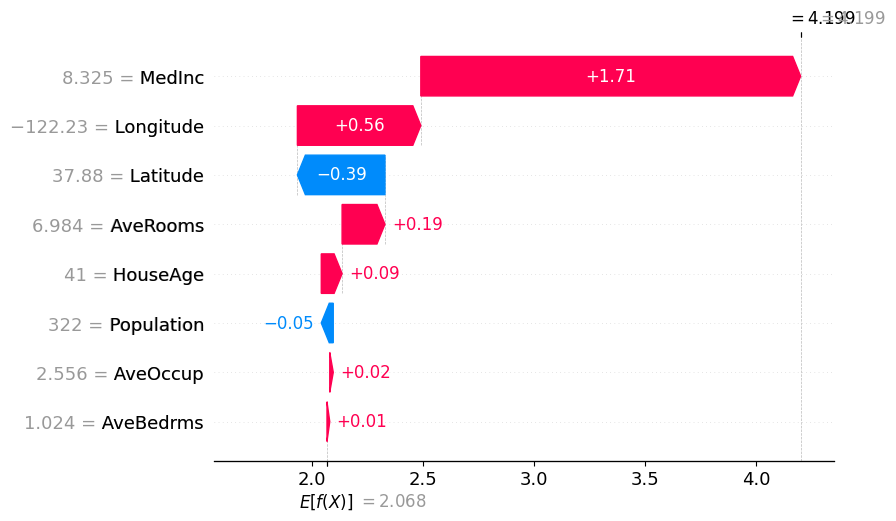

In [ ]:


# train an XGBoost model
X, y = shap.datasets.california()
model = xgboost.XGBRegressor().fit(X, y)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])  # Waterfall plot (individual prediction)

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue. Another way to visualize the same explanation is to use a force plot (these are introduced in our Nature BME paper):

In [ ]:
shap.initjs()
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[0]) # doesnt work in jupyter notebook
# use matplotlib-based visualizations instead

In [ ]:
shap.save_html("../outputs/shap_force_plot.html", shap.plots.force(shap_values[0]))


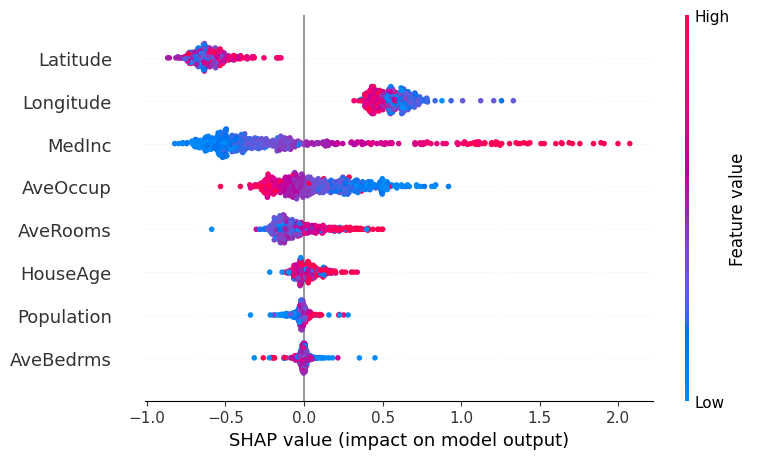

In [ ]:
shap.summary_plot(shap_values[:500])

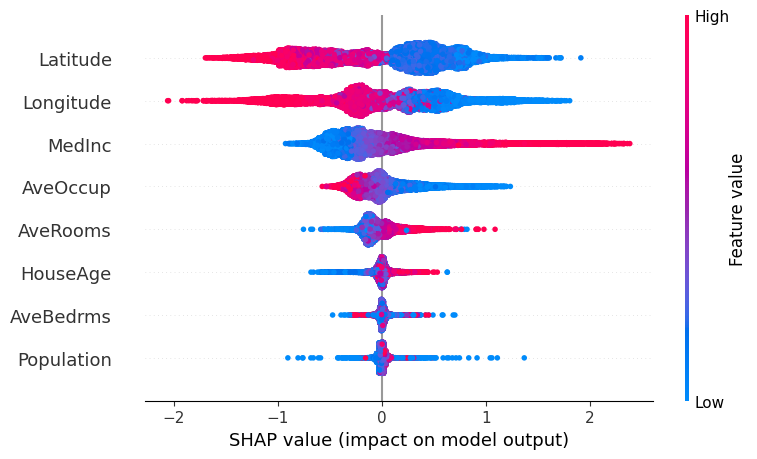

In [ ]:
shap.summary_plot(shap_values, X)  # Summary plot for all predictions


To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in predicted house price as the latitude changes. Vertical dispersion at a single value of latitude represents interaction effects with other features. To help reveal these interactions we can color by another feature. If we pass the whole explanation tensor to the color argument the scatter plot will pick the best feature to color by. In this case it picks longitude.

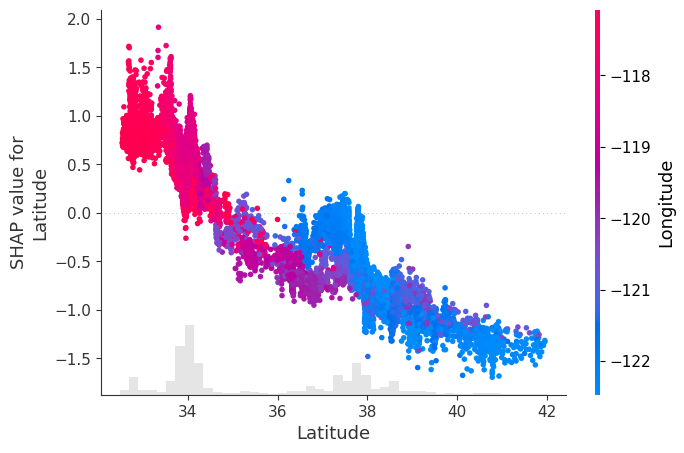

In [ ]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:, "Latitude"], color=shap_values)

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). This reveals for example that higher median incomes improves the predicted home price.


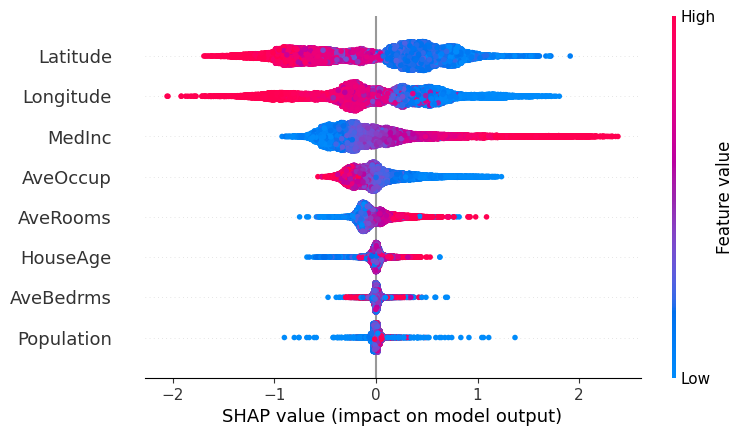

In [ ]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs):

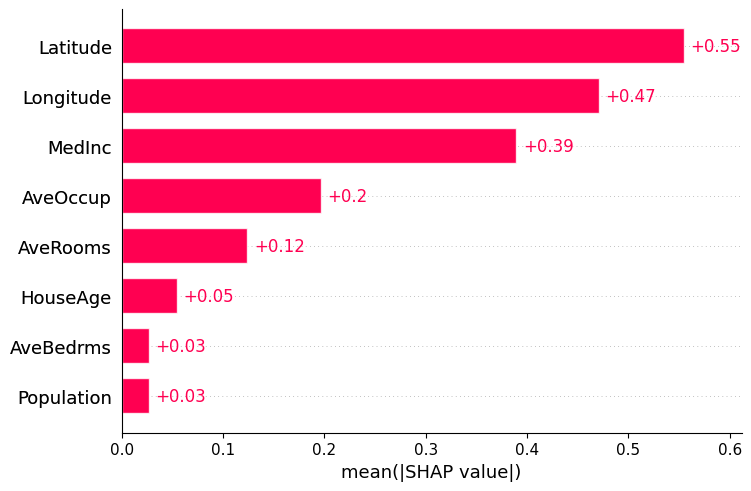

In [ ]:
shap.plots.bar(shap_values)

Natural language example (transformers)

SHAP has specific support for natural language models like those in the Hugging Face transformers library. By adding coalitional rules to traditional Shapley values we can form games that explain large modern NLP model using very few function evaluations. Using this functionality is as simple as passing a supported transformers pipeline to SHAP:

In [ ]:
import transformers

# load a transformers pipeline model
# model = transformers.pipeline('sentiment-analysis', return_all_scores=True)
model = transformers.pipeline('sentiment-analysis', top_k=None)

# explain the model on two sample inputs
explainer = shap.Explainer(model)
shap_values = explainer(["What a great movie! ...if you have no taste."])

# visualize the first prediction's explanation for the POSITIVE output class
shap.plots.text(shap_values[0, :, "POSITIVE"])

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


Model agnostic example with KernelExplainer (explains any function)
Kernel SHAP uses a specially-weighted local linear regression to estimate SHAP values for any model. Below is a simple example for explaining a multi-class SVM on the classic iris dataset.

In [ ]:
# X_test

# y_test

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


0.9999999709393045

Shape of transformed Train set: (673318, 4)
Feature Names 
 Index(['∅_de/lu_neighbours_€/mwh', 'denmark_1_€/mwh', 'netherlands_€/mwh',
       'czech_republic_€/mwh'],
      dtype='object')


/Users/okpo/Desktop/Onward/dynamic_rhythm_env/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but SelectFromModel was fitted without feature names



Incremental Training: 100%|██████████| 18/18 [00:13<00:00,  1.33trees/s]


/Users/okpo/Desktop/Onward/dynamic_rhythm_env/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but RandomForestRegressor was fitted without feature names



0.9999999991488817

In [ ]:
# X_train_new.info()

In [ ]:
# from sklearn.ensemble import RandomForestRegressor

# rf_modified = RandomForestRegressor(n_estimators=50, random_state=42, verbose=0, n_jobs=-1)
# rf_modified.fit(X_train_new, y_train)


In [ ]:
# # creating an explainer for our model
# explainer = shap.TreeExplainer(rf_modified) # we only need to pass our  fitted model to tree explainer. 
#                                     #No background dataset in 'data' argument required for tree models as it
#                                     #is automatically received through the model tree object.

# # finding out the shap values using the explainer
# shap_values = explainer.shap_values(X_train_new)

# # Expected/Base/Reference value = the value that would be predicted if we didn’t know any features of the current output”
# print('Expected Value:', explainer.expected_value)

In [ ]:
# SHAP Explainer (Tree-based models vs others)
# if hasattr(rf_model, "predict_proba") or hasattr(rf_model, "feature_importances_"):
#     explainer = shap.TreeExplainer(rf_model)
# else:
#     explainer = shap.Explainer(rf_model, X_train)

# shap_values = explainer(X_test)


# background = shap.sample(X_train, 50)  # Select 50 representative points

# # Use Kernel SHAP with a reduced background set
# # explainer = shap.KernelExplainer(svm.predict_proba, background)

# # Compute SHAP values for a subset of test data
# shap_values = explainer.shap_values(X_test.iloc[:5], nsamples=100)

# # Visualize
# shap.summary_plot(shap_values, X_test.iloc[:5])

## ✅ SHAP Global Feature Importance (Static Plot)
# shap.summary_plot(shap_values, X_test, show=False)
# plt.title("SHAP Feature Importance (Global)")
# plt.show()

In [ ]:


## ✅ SHAP Local Explanation (Interactive Force Plot)
# print(f"\n🔹 SHAP Explanation for Test Sample {sample_idx}\n")
shap.initjs()  # Enables interactive visualizations
display.display(shap.force_plot(explainer.expected_value, shap_values[0].values, X_test.iloc[0]))

print("\n🔹 Generating LIME explanation...\n")

In [ ]:
import sklearn
import shap
from sklearn.model_selection import train_test_split


# print the JS visualization code to the notebook
shap.initjs()

# train a SVM classifier
X_trainn,X_testt,Y_trainn,Y_testt = train_test_split(*shap.datasets.iris(), test_size=0.2, random_state=0)
svm = sklearn.svm.SVC(kernel='rbf', probability=True)
svm.fit(X_trainn, Y_trainn)

# background = shap.kmeans(X_trainn, 10)  # Reduce to 10 cluster centers
#  Reduce background data size (random sampling)
background = shap.sample(X_trainn, 50)  # Select 50 representative points

# Use Kernel SHAP with a reduced background set
explainer = shap.KernelExplainer(svm.predict_proba, background)

# Compute SHAP values for a subset of test data
shap_values = explainer.shap_values(X_testt.iloc[:5], nsamples=100)

# Visualize
shap.summary_plot(shap_values, X_testt.iloc[:5])

In [ ]:





# use Kernel SHAP to explain test set predictions
# explainer = shap.KernelExplainer(svm.predict_proba, X_trainn, link="logit")
# shap_values = explainer.shap_values(X_testt, nsamples=100)

# # plot the SHAP values for the Setosa output of the first instance
# shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:], link="logit")
# shap.force_plot(shap_values, X_testt.iloc[:5])
# shap.force_plot(explainer.expected_value, X_testt.iloc[:5])


In [ ]:
# shap.force_plot(base_value=explainer.expected_value,
# shap_values=shap_values[10,:],
# features=X_train.iloc[10,:])

In [ ]:
# ## ✅ LIME Explainer
# lime_explainer = lime.lime_tabular.LimeTabularExplainer(
#     X_train.values if hasattr(X_train, 'values') else X_train, 
#     feature_names=X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])], 
#     class_names=["Target"], 
#     mode="regression" if hasattr(model, "predict") and not hasattr(model, "predict_proba") else "classification"
# )

# ## ✅ LIME Local Explanation (Interactive HTML)
# exp = lime_explainer.explain_instance(X_test.iloc[sample_idx].values, model.predict, num_features=num_features)
# html_exp = exp.as_html()
# display.display(display.HTML(html_exp))  # Render in a Jupyter Notebook

# return {
#     "shap_values": shap_values,
#     "lime_explanation": exp
# }